TOC

- [Run Stan](#Run-Stan-model)
- [Post process](#Post-process)
    - [HMC](#HMC)
    - [Pair plots](#Pair-plots)
    - [Phase spaces](#Phase-spaces)
    - [PPC sEEG](#PPC-sEEG)

In [1]:
%pylab inline
# comment on lofi screen
%config InlineBackend.figure_format = 'retina'
import lib
lib.cmdstan_path('~/cmdstan-2.17.0');

Populating the interactive namespace from numpy and matplotlib


## Run Stan model

Compile first,

In [2]:
lib.compile_model('vep-fe-rev-05.stan')

--- Translating Stan model to C++ code ---
bin/stanc  /Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05.stan --o=/Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05.hpp
Model name=vep_fe_rev_05_model
Input file=/Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05.stan
Output file=/Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05.hpp

--- Linking C++ model ---
clang++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -I src -I stan/src -isystem stan/lib/stan_math/ -DEIGEN_NO_DEBUG -DFUSION_MAX_VECTOR_SIZE=12 -stdlib=libc++ -Wno-unknown-warning-option -Wno-unused-function -Wno-tautological-compare -Wsign-compare -DNO_FPRINTF_OUTPUT -pipe   -O3 -o /Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05 src/cmdstan/main.cpp -include /Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05.hpp stan/lib/stan_math/lib/cvodes_2

Run multiple chains,

In [3]:
%%bash
model=vep-fe-rev-05
rm -f ${model}.optimize.*.{out,csv}

for i in `seq 4`
do
    j=0
    while ! ./$model id=$((100*$j + $i)) \
        optimize \
        data file=data.R \
        output file=${model}.optimize.$i.csv refresh=10 \
        &> ${model}.optimize.$i.out
    do
        j=$(($j + 1))
        echo "trying again.. (j=$j)"
    done
done

Check all optimizations OK

In [4]:
!tail -n2 *optimize*out

==> vep-fe-rev-05.optimize.1.out <==
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

==> vep-fe-rev-05.optimize.2.out <==
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

==> vep-fe-rev-05.optimize.3.out <==
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

==> vep-fe-rev-05.optimize.4.out <==
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Convert optimizations to R format

In [5]:
for i in range(1, 5):
    csv = lib.parse_csv(f'vep-fe-rev-05.optimize.{i}.csv')
    data = {k: v[0] for k, v in csv.items()}
    # bug in my rdump or stan file..
    data['x_eta'] = data['x_eta'].T
    data['z_eta'] = data['z_eta'].T
    lib.rdump(f'vep-fe-rev-05.optimize.{i}.csv.R', data)

Now run MC chains

In [53]:
%%bash
model=vep-fe-rev-05
rm -f ${model}.sample.*.{out,csv}
for i in `seq 2`
do
    ./$model id=$i\
        sample save_warmup=1 num_warmup=200 num_samples=200 \
            adapt \
                delta=0.8 \
            algorithm=hmc \
                engine=nuts \
                    max_depth=7 \
        data file=data.R \
        output file=${model}.sample.$i.csv refresh=1 \
        &> ${model}.sample.$i.out &
done

Check status..

In [75]:
!tail -n 1 vep-fe-rev-05.sample.*.out
csv = lib.parse_csv('vep-fe-rev-05.sample.*.csv', merge=False)

==> vep-fe-rev-05.sample.1.out <==


==> vep-fe-rev-05.sample.2.out <==



Maybe stop them if required..

In [52]:
!killall vep-fe-rev-05

## Post process

_Often I'm running next version of model while analyzing previous version, so it's helpful to note git hash_

In [273]:
!git rev-parse HEAD

010bc9b9f27e644a465ecfd7ea244a91d9a1f2a4


### HMC

Plot HMC stats (while running)

/Users/maedoc/miniconda3/envs/scipy/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


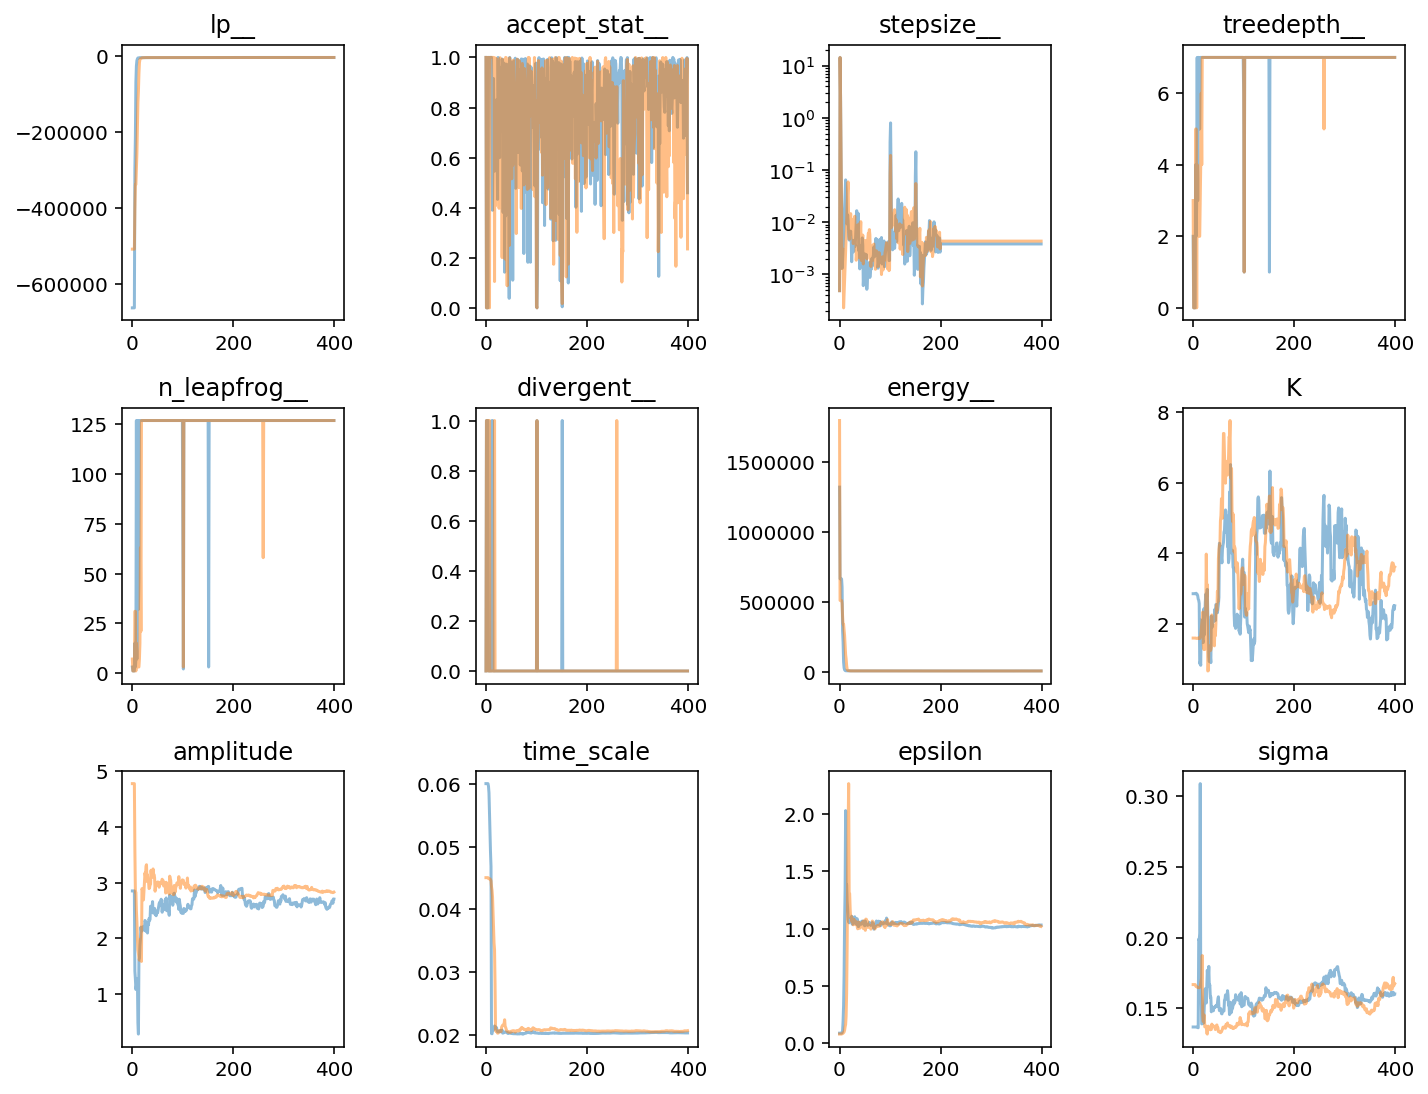

In [76]:
figure(figsize=(10, 10))
skip = 0
extras = 'K time_scale sigma epsilon amplitude'.split()
for csvi in csv:
    i = 1
    for key in csvi.keys():
        if key[-2:] == '__' or key in extras:
            subplot(4, 4, i)
            plot(csvi[key][skip:], alpha=0.5)
            if key in ('stepsize__', ):
                gca().set_yscale('log')
            title(key)
            i += 1
tight_layout()

### Pair plots

_Skip 150 warmup samples, plot different chains by color_

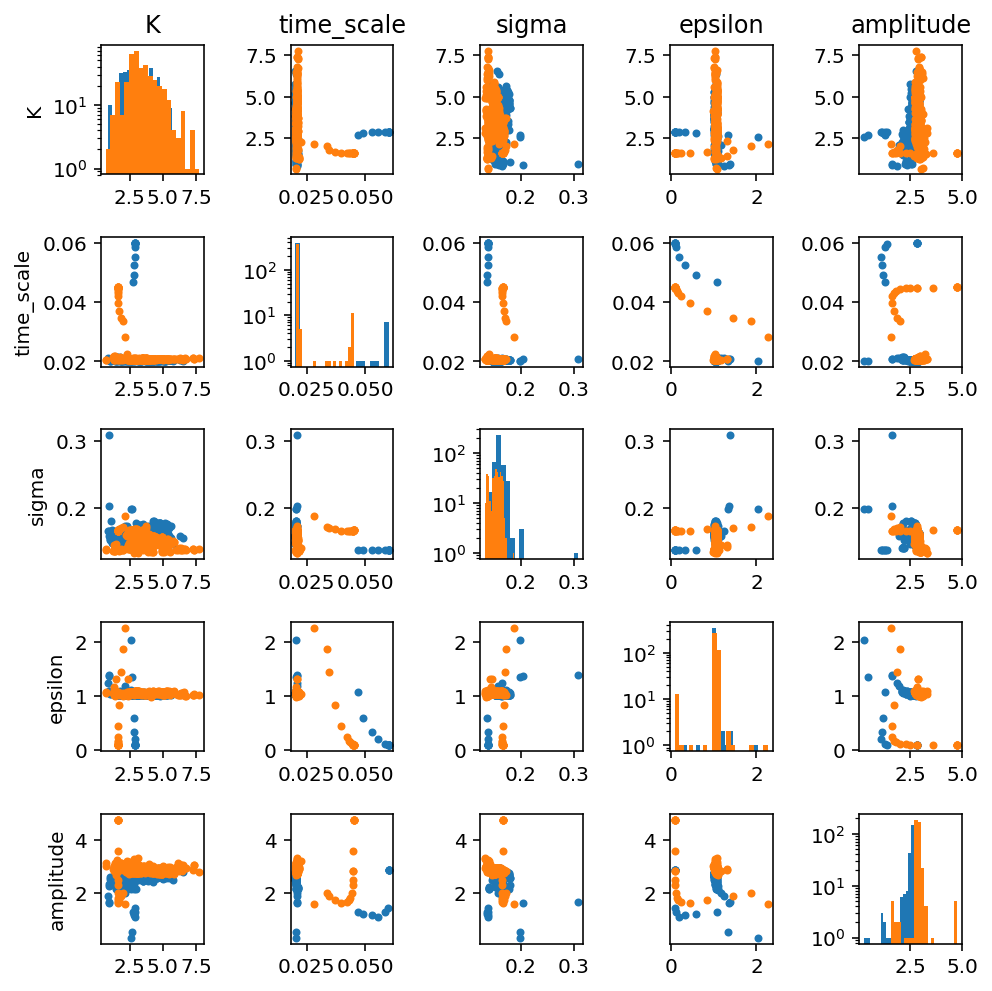

In [77]:
figure(figsize=(7, 7))
lib.reload()
lib.viz_pair_plots(csv, extras, skip=0)

### Phase spaces

Phase space plots tell about the linear/nonlinear behavior of the neural mass model.  Specifically, the model predicts transition between healthy and seizure states when `x` passes from negative knee to positive knee.

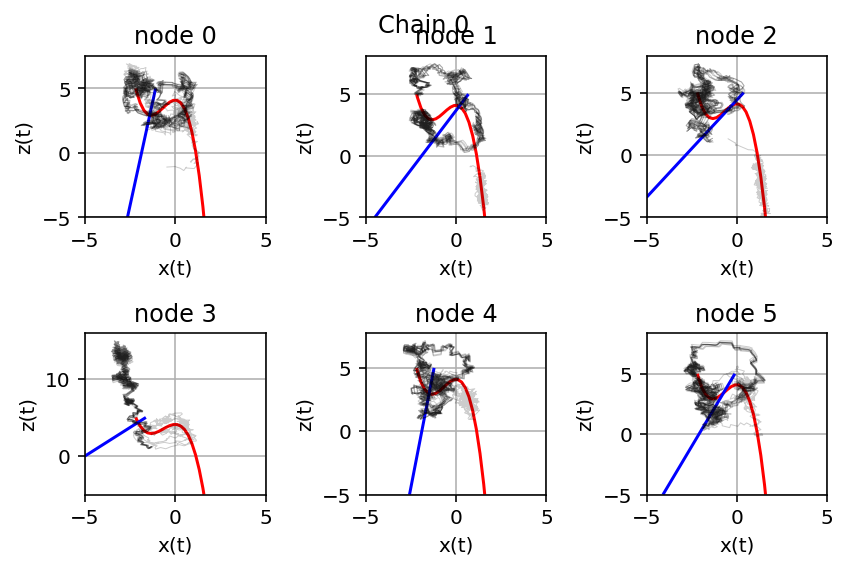

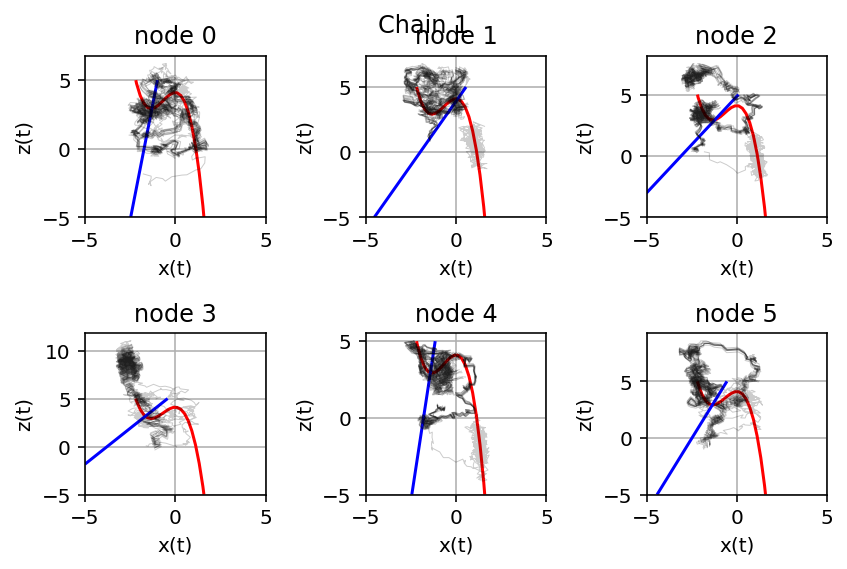

In [78]:
lib.reload()
for i, csvi in enumerate(csv):
    figure()
    lib.viz_phase_space(csvi)
    suptitle(f'Chain {i}')
    tight_layout()

Some chains were running into instability with linear `k * gx` coupling, now much more stable with `tanh(k * gx)`.

### PPC sEEG

Posterior predictive traces for observation,

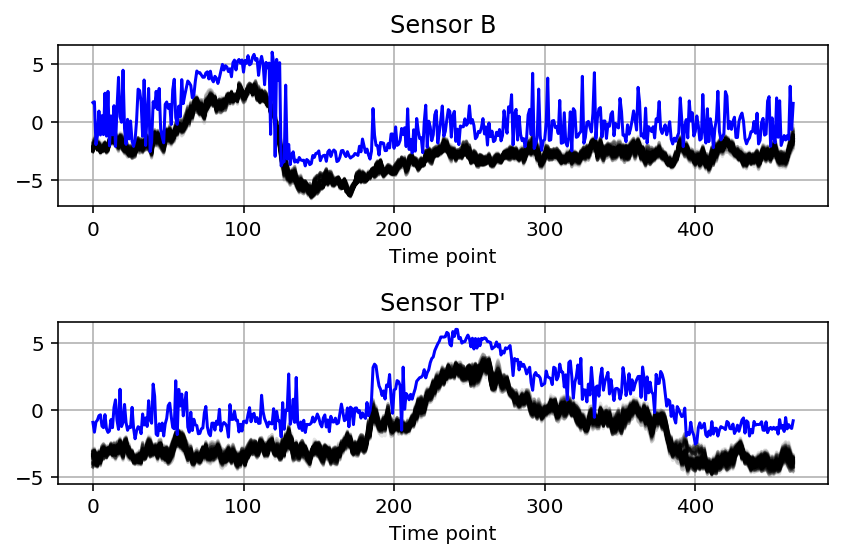

In [99]:
i = 1  # chain id
skip = 200

x = csv[i]['x'][skip:, :]
gain = np.load('data.R.npz')['gain']

yh0, yh1 = csv[i]['amplitude'][skip:, newaxis]*log(gain.dot(exp(x))) + csv[i]['offset'][skip:, newaxis]
y0, y1 = np.load('data.R.npz')['seeg_log_power'].T

subplot(211)
plot(yh0.T, 'k', alpha=0.1, label='PPC SLP');
plot(y0.T, 'b', label='SLP')
title("Sensor B"), xlabel('Time point'), grid(1)

subplot(212)
plot(yh1.T, 'k', alpha=0.1, label='PPC SLP');
plot(y1.T, 'b', label='SLP')
title("Sensor TP'"), xlabel('Time point'), grid(1)

tight_layout()

### X0 values

Excitability estimates per region, parameter of interest

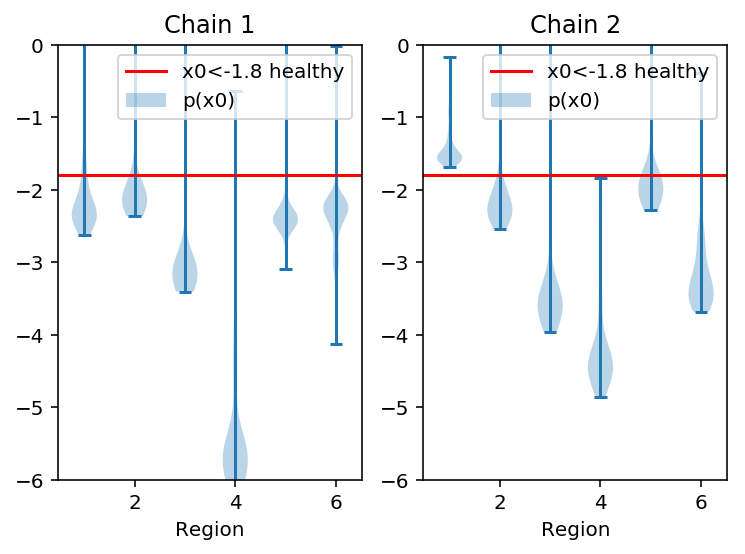

In [109]:
for i, csvi in enumerate(csv):
    subplot(1, 2, i + 1)
    axhline(-1.8, color='r');
    violinplot(csvi['x0'])
    ylim([-6, 0])
    legend(('x0<-1.8 healthy','p(x0)', )), xlabel('Region'), title(f'Chain {i+1}')